# 4. Training the interatomic potential model

- The model should be trained on reference dataset (usually ab-initio calculations) to correctly behave
- In below example we use AIMD trajectory of ethanol molecule to learn PES of ethanol
  - AIMD trajectory contains many conformations of molecule so that we can expect the model to learn general relationship between conformation and potential energy. 
  - Energies and forces are recalculated using CCSD(T)/cc-pVTZ theory.

In [1]:
from ccsd_t_dataset import create_ccsd_t_dataset

train_dataset, test_dataset = create_ccsd_t_dataset()
train_dataset, test_dataset

Processing training dataset: 0it [00:00, ?it/s]
Processing training dataset: 1000it [00:00, 1803.56it/s]

Processing test dataset: 1it [00:00,  1.66it/s]
Processing test dataset: 359it [00:00, 688.53it/s]
Processing test dataset: 1000it [00:00, 1135.34it/s][A


(InMemoryDataset(1000), InMemoryDataset(1000))

- First let's explore some statistics of dataset

Average energy: -4209.991 eV
Stddev of energy: 0.199


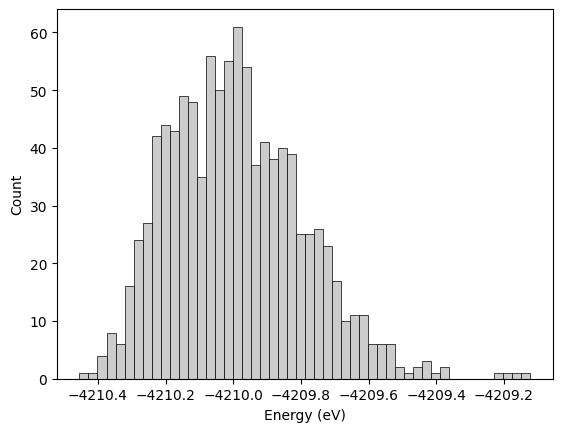

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np

energy_mean = train_dataset.get_statistics("energy", reduce="mean")
energy_stdev = train_dataset.get_statistics("energy", reduce="std")
print(f"Average energy: {energy_mean:.3f} eV")
print(f"Stddev of energy: {energy_stdev:.3f}")

all_energies = np.array([data["energy"].item() for data in train_dataset])

plt.figure()
plt.xlabel("Energy (eV)")
plt.ylabel("Count")
plt.hist(all_energies, bins=50, facecolor="#CCCCCC", edgecolor="k", lw=0.5)
plt.show()

- Since the energy is shifted a lot, we should do some scaling
- Instead of directly scaling the dataset, `aml` applies scale & shift layer to `energy_model` itself:

    $$
    E_i^{(z)} = c^{(z)} (\hat E_i) + s^{(z)}
    $$
    $$
    E = \sum E_i
    $$
    
    where $c^{(z)}$ and $s^{(z)}$ are per-element scaling and shifting factors.

- Shifting is usually done by the energy of isolated atoms (=atomic energies)
  - This is equivalent to predicting negative atomization energy $-E_{at} = E - \sum_i{E_i^\mathrm{isolated}}$
  - If atomic energies are not available it can be estimated using least square fit. ("auto")
- Scaling can be done by stddev of energy or per-species force rms(root mean square). Usually force rms works good.

- These factors can be assigned using `energy_model.initialize`

In [3]:
from aml.models.energy_models import SchNet
from aml.models import InterAtomicPotential

schnet = SchNet(species=["H", "C", "O"], cutoff=5.0)

print("Scaling factors per element:")
print(schnet.species_energy_scale.scales.data) 
print("Shifting factors per element:")
print(schnet.species_energy_scale.shifts.data)

E = schnet(train_dataset[0])
print("E =", E.item())

Scaling factors per element:
tensor([1., 1., 1.])
Shifting factors per element:
tensor([0., 0., 0.])
E = 15.966598510742188


- The predicted energy is very far from average energy (~ -4210 eV)

In [4]:
schnet.initialize(
    energy_shift_mode="atomic_energies",
    energy_scale_mode="force_rms",
    atomic_energies="auto",
    energy_scale="auto",
    trainable_scales=False, # if True, scale&shift layer is learned during training
    dataset=train_dataset,
)
print("Scaling factors per element:")
print(schnet.species_energy_scale.scales.data) 
print("Shifting factors per element:")
print(schnet.species_energy_scale.shifts.data)

Scaling factors per element:
tensor([0.9321, 1.6817, 1.3943])
Shifting factors per element:
tensor([-616.0963, -205.3654, -102.6827])


In [5]:
E = schnet(train_dataset[0])
print(E)

tensor([-4193.9575], grad_fn=<ScatterAddBackward0>)


- Now energy is close to target range.

## How to train the IAP model

- In `aml` the loss function for training the model is defined as sum of weighted individual loss per property:
  $$
  \mathcal{L} = \sum_p w_p \mathcal{L}_p
  $$
  where $p$ is target property(ex. energy, force, ...) and $\mathcal{L}_p$ is loss for property $p$.

- Usually trained on energy and force
- Loss function $\mathcal{L}$ can be MSE loss or Huber loss(like MAE but smooth at minimum)

## Train model using pytorch lightning

- [Pytorch Lightning](https://lightning.ai/docs/pytorch/latest/) (PL) is training library for pytorch(similar to `keras` for TF)
- PL uses `LightningModule` to define training behavior (training step, optimizer, ...)
- In `aml.train` there is `PotentialTrainingModule` subclassing `LightningModule` which is designed for training interatomic potential.
- Let's dive into example

### `PotentialTrainingModule`

- Wraps `InterAtomicPotential` and adds common training procedure
- Loss function, metrics, optimizer, and data scaling are defined in `PotentialTrainingModule`

In [7]:
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger
from aml.models import InterAtomicPotential
from aml.train.lightning_modules import PotentialTrainingModule
from aml.train.callbacks import ExponentialMovingAverage

model = InterAtomicPotential(schnet)

training_module = PotentialTrainingModule(
    # Model
    model=model,
    # Loss
    loss_keys=("energy", "force"), # properties to incorporate in loss
    loss_weights=(0.01, 1.0), # weights of individual loss
    per_atom_loss_keys=(), # If any key is in this parameter the loss is calculated in per-atom basis
    loss_type="mse_loss",
    metrics=[            # Metrics to monitor. name: (per_atom)_{property}_{mae or rmse}
        "energy_mae",
        "force_mae",
        "per_atom_energy_mae",
        "energy_rmse",
        "force_rmse"
    ],
    # Optimizer
    optimizer="adam",
    optimizer_config={"lr": 0.001},
    lr_scheduler="reduce_lr_on_plateau",
    lr_scheduler_config={"patience": 10, "factor": 0.5},
    # Below are initializer
    energy_shift_mode="atomic_energies",
    energy_scale_mode="force_rms",
    atomic_energies="auto",
    energy_scale="auto",
    trainable_scales=False,
)
training_module.initialize(train_dataset) # Must be called before training. Initializes energy_model

### Callbacks

- Callback is the function which is periodically called during training
  - On epoch end, on batch end, ...
- See [here](https://lightning.ai/docs/pytorch/latest/api_references.html#callbacks) for list of built-in callbacks in PL
- Below we use `ModelCheckpoint`, `RichProgressBar`, and `ExponentialMovingAverage`
  - `ExponentialMovingAverage` is defined in `aml`, which smoothes model parameters to reduce noise in step-loss curve.

In [ ]:
callbacks = [
    ModelCheckpoint(
        dirpath="checkpoints", filename="best_model", save_last=True, save_top_k=1, monitor="val_loss"
    ), # Checkpointing model periodically
    RichProgressBar(), # Progress bar
    ExponentialMovingAverage(0.99), # Smoothes model weights through epoch.
]

### Logger

- Logger monitors metrics and log to various targets (file, tensorboard, wandb, ...)
- Here we use tensorboard

In [ ]:
logger = TensorBoardLogger("tensorboard", name="ethanol_ccsd_t_schnet") # Log training using tensorboard

### Trainer

- Trainer is the main object for model training
- It executes the training and validation loops

In [9]:
from torch_geometric.loader import DataLoader
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

train_set, val_set = train_dataset.split(0.95)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)

trainer = L.Trainer(
    accelerator=device,  # Device to use
    devices=1,  # Number of devices
    max_epochs=10, # Maximum epochs
    gradient_clip_val=10.0,  # Threshold of gradient clipping 
    callbacks=callbacks,
    logger=logger,
)
trainer.fit(training_module, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/mjhong/Documents/Github/aml/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/mjhong/Documents/Github/aml/venv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /Users/mjhong/Documents/Github/aml/tutorials/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


┏━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name    ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model   │ InterAtomicPotential │  455 K │
│ 1 │ loss_fn │ WeightedSumLoss      │      0 │
└───┴─────────┴──────────────────────┴────────┘

Trainable params: 455 K                                                                                            
Non-trainable params: 6                                                                                            
Total params: 455 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/mjhong/Documents/Github/aml/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_conn
ector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this
machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/Users/mjhong/Documents/Github/aml/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_conn
ector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this
machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

`Trainer.fit` stopped: `max_epochs=10` reached.


- Meanwhile you can monitor the progress using tensorboard:
  `tensorboard --logdir tensorboard`
- After training is done, the best model can be loaded

In [10]:
from aml.simulations import AMLCalculator

trained_model = InterAtomicPotential.load("checkpoints/best_model.ckpt")
calc = AMLCalculator(trained_model, device=device)

In [11]:
import numpy as np
import ase.build

def make_ethanol_ch3_rotation_traj():
    atoms = ase.build.molecule("CH3CH2OH")
    images = []
    angles = np.linspace(0, 360, 500)
    for angle in angles:
        new = atoms.copy()
        new.rotate_dihedral(4, 1, 0, 7, angle, indices=[6, 0, 7, 8])
        images.append(new)
    return angles, images

angles, images = make_ethanol_ch3_rotation_traj()
energies = np.array([calc.get_potential_energy(atoms) for atoms in images])

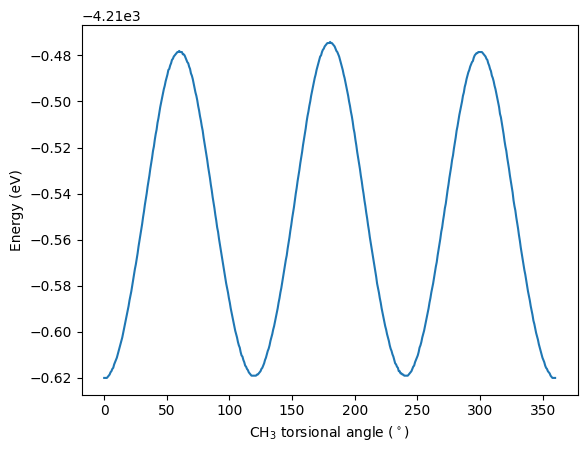

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("CH$_3$ torsional angle ($^\circ$)")
plt.ylabel("Energy (eV)")
plt.plot(angles, energies)
plt.show()

- Now PES looks pretty good.

### Training using `PotentialTrainer`

- The model can be trained using `config.yaml` and `PotentialTrainer`.
- See `examples` for detail